In [ ]:
import pandas as pd
from nltk import agreement


data = pd.read_csv('labeled-dataset.tsv', sep='\t')
data = data.drop(['social_support', 'conflict', 'trust', 'fun',
       'similarity', 'identity', 'respect', 'romance', 'power',
       'other',], axis=1)
data["is_k"] = data["knowledge"].apply(lambda x: 0 if x == 0 else 1)
data['is_k'].value_counts()


is_k
0    5006
1    2849
Name: count, dtype: int64

In [116]:
#SemEval 2017 Dataset with individual annotators
data = pd.read_csv('SemEval2016-Task6-raw-annotations-sentiment.csv')
data['binned'] = np.where(data['Sentiment'] <= 2, 0, 1)
print(data.head())

worker1 = data[data['Worker ID'] == 'worker_1']
worker2 = data[data['Worker ID'] == 'worker_2']
worker3 = data[data['Worker ID'] == 'worker_3']

worker1.columns = ['Worker ID', 'Instance ID', 'Tweet','Sentiment', 'Worker1']
worker2.columns = ['Worker ID', 'Instance ID', 'Tweet', 'Sentiment','Worker2']
worker3.columns = ['Worker ID', 'Instance ID', 'Tweet', 'Sentiment','Worker3']
data = worker1.merge(worker2, on=['Instance ID', 'Tweet']).merge(worker3, on=['Instance ID', 'Tweet'])
data['majority_vote'] = data[['Worker1', 'Worker2', 'Worker3']].mode(axis=1)[0]


  Worker ID  Instance ID                                              Tweet  \
0  worker_1        20582  @realDonaldTrump  WE WANT TRUMP! WE WANT TRUMP...   
1  worker_2        20582  @realDonaldTrump  WE WANT TRUMP! WE WANT TRUMP...   
2  worker_3        20582  @realDonaldTrump  WE WANT TRUMP! WE WANT TRUMP...   
3  worker_4        20582  @realDonaldTrump  WE WANT TRUMP! WE WANT TRUMP...   
4  worker_5        20582  @realDonaldTrump  WE WANT TRUMP! WE WANT TRUMP...   

   Sentiment  binned  
0          1       0  
1          1       0  
2          1       0  
3          1       0  
4          1       0  


In [117]:
# perturbing data
import numpy as np

np.random.seed(42)  # For reproducibility

# Define the probability of flipping (e.g., 30% of the rows)
probabilities = np.arange(0, 1.05, 0.05).tolist()
for flip_prob in probabilities:
    # Create a mask to determine which rows to flip
    flip_prob = round(flip_prob, 2)
    mask = np.random.rand(len(data)) < flip_prob

    # Flip the values (0 → 1, 1 → 0)
    data[str(flip_prob)] = data['Worker1'].where(~mask, 1 - data['Worker1'])
    
print(data)


     Worker ID_x  Instance ID  \
0       worker_1        20582   
1       worker_1        20146   
2       worker_1        20336   
3       worker_1        20666   
4       worker_1         2109   
...          ...          ...   
1171    worker_1         2721   
1172    worker_1        10437   
1173    worker_1         2419   
1174    worker_1         2419   
1175    worker_1          375   

                                                  Tweet  Sentiment_x  Worker1  \
0     @realDonaldTrump  WE WANT TRUMP! WE WANT TRUMP...            1        0   
1     I admire how real and unapologetic Donald Trum...            1        0   
2     Everything Donald Trump said was 100% true tho...            1        0   
3     @realDonaldTrump we need you in office.. Keep ...            1        0   
4     RT @HillaryHaikus: #Ready because one day girl...            1        0   
...                                                 ...          ...      ...   
1171  When you abort a baby, you don

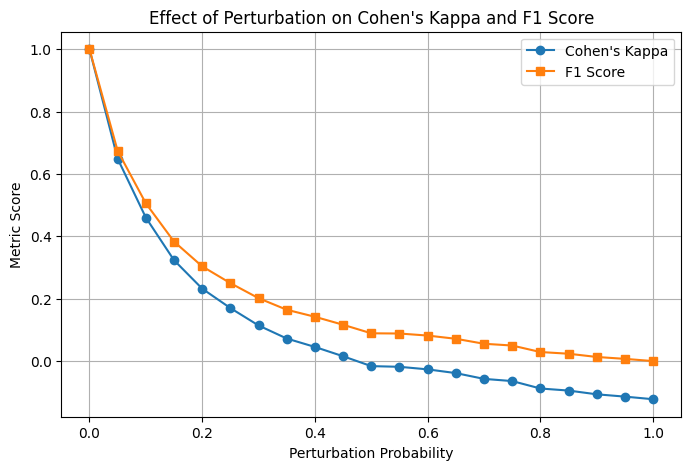

In [118]:
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, f1_score

# Assuming df is your DataFrame
perturbation_probs = probabilities #np.arange(0, 1.05, 0.05)  # Column names representing perturbation probabilities
metrics = {"perturbation_prob": [], "cohen_kappa": [], "f1_score": []}
df = data
for prob in perturbation_probs:
    prob = round(prob, 2)  # Round to 2 decimal places
    col_name = str(prob)  # Ensure column name matches expected format
    if col_name in df.columns:
        kappa = cohen_kappa_score(df["Worker1"], df[col_name])
        f1 = f1_score(df["Worker1"], df[col_name], average='binary')  # Adjust for multiclass if needed
        
        metrics["perturbation_prob"].append(prob)
        metrics["cohen_kappa"].append(kappa)
        metrics["f1_score"].append(f1)

# Convert results into a DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot results
plt.figure(figsize=(8,5))
plt.plot(metrics_df["perturbation_prob"], metrics_df["cohen_kappa"], label="Cohen's Kappa", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["f1_score"], label="F1 Score", marker='s')
plt.xlabel("Perturbation Probability")
plt.ylabel("Metric Score")
plt.title("Effect of Perturbation on Cohen's Kappa and F1 Score")
plt.legend()
plt.grid(True)
plt.show()


## Case 1

In [ ]:
def calculate_agreements(prob):
    rater1 = data['Worker1'].to_list()
    rater2 = data['Worker2'].to_list()
    rater3 = data['Worker3'].to_list()
    rater4 = data[str(prob)].to_list() #model

    annotators=[[0,str(i),str(rater1[i])] for i in range(0,len(rater1))] + \
            [[1,str(i),str(rater2[i])] for i in range(0,len(rater2))]  + \
            [[2,str(i),str(rater3[i])] for i in range(0,len(rater3))]  

    model1=[[1,str(i),str(rater2[i])] for i in range(0,len(rater2))]  + \
            [[2,str(i),str(rater3[i])] for i in range(0,len(rater3))]  + \
            [[3,str(i),str(rater4[i])] for i in range(0,len(rater4))]  

    model2=[[0,str(i),str(rater1[i])] for i in range(0,len(rater1))] + \
            [[2,str(i),str(rater3[i])] for i in range(0,len(rater3))]  + \
            [[3,str(i),str(rater4[i])] for i in range(0,len(rater4))]  

    model3=[[0,str(i),str(rater1[i])] for i in range(0,len(rater1))] + \
            [[1,str(i),str(rater2[i])] for i in range(0,len(rater2))]  + \
            [[3,str(i),str(rater4[i])] for i in range(0,len(rater4))]  

    ratingtask1 = agreement.AnnotationTask(data=annotators)

    #print("Krippendorff's alpha " +str(ratingtask.alpha()))
    #print("Fleiss' kappa " + str(ratingtask.multi_kappa()))
    ratingtask2 = agreement.AnnotationTask(data=model1)
    ratingtask3 = agreement.AnnotationTask(data=model2)
    ratingtask4 = agreement.AnnotationTask(data=model3)
    return [ratingtask1, ratingtask2, ratingtask3, ratingtask4]





In [120]:
metrics = {"perturbation_prob": [], "k1": [], "k2": [], "k3": [], "k4": [], "f1_score": []}
df = data
for prob in perturbation_probs:
    prob = round(prob, 2)  # Round to 2 decimal places
    col_name = str(prob)  # Ensure column name matches expected format
    if col_name in df.columns:
        ks= calculate_agreements(prob)
        k1 = ks[0].alpha()
        k2 = ks[1].alpha()
        k3 = ks[2].alpha()
        k4 = ks[3].alpha()
        f1 = f1_score(df["majority_vote"], df[col_name], average='binary')
        metrics["perturbation_prob"].append(prob)
        metrics["k1"].append(k1)
        metrics["k2"].append(k2)
        metrics["k3"].append(k3)
        metrics["k4"].append(k4)
        metrics["f1_score"].append(f1)

# Convert results into a DataFrame
metrics_df = pd.DataFrame(metrics)



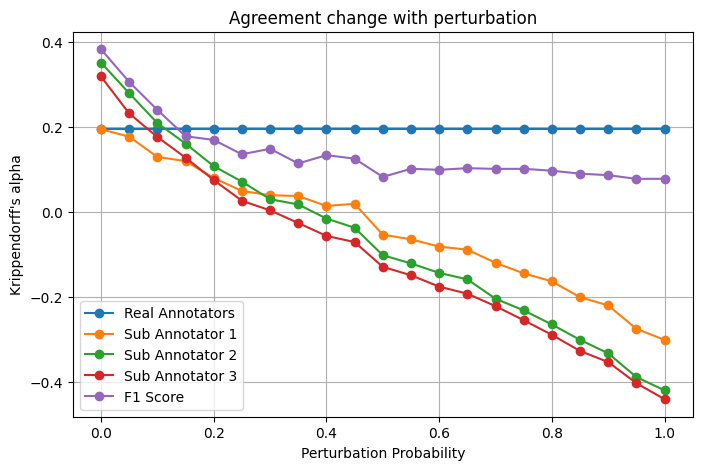

In [121]:
# Plot results
plt.figure(figsize=(8,5))
plt.plot(metrics_df["perturbation_prob"], metrics_df["k1"], label="Real Annotators", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["k2"], label="Sub Annotator 1", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["k3"], label="Sub Annotator 2", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["k4"], label="Sub Annotator 3", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["f1_score"], label="F1 Score", marker='o')

plt.xlabel("Perturbation Probability")
plt.ylabel("Krippendorff's alpha")
plt.title("Agreement change with perturbation")
plt.legend()
plt.grid(True)
plt.show()

### Raw Agreement

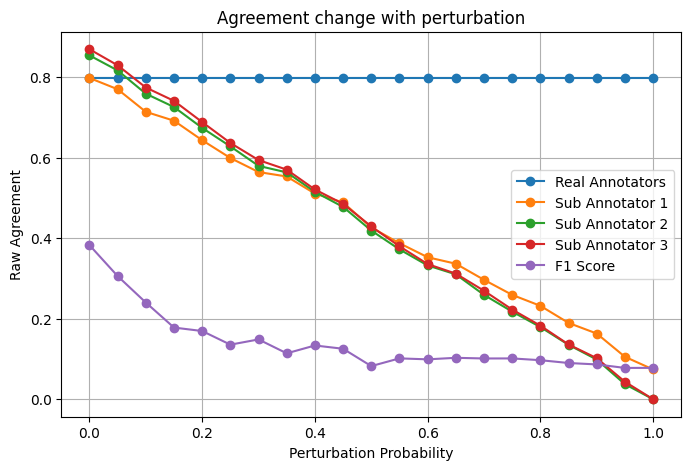

In [128]:
def raw_agreement(df):
    agreements = (df.nunique(axis=1) == 1).sum()
    total_items = len(df)
    raw_agreement = agreements / total_items  
    return raw_agreement  

metrics = {"perturbation_prob": [], "k1": [], "k2": [], "k3": [], "k4": [], "f1_score": []}
df = data
for prob in perturbation_probs:
    prob = round(prob, 2)  # Round to 2 decimal places
    col_name = str(prob)  # Ensure column name matches expected format
    if col_name in df.columns:
        #subset = data[['Worker1', 'Worker2', 'Worker3', col_name]]
        k1 = raw_agreement(data[['Worker1', 'Worker2', 'Worker3']])
        k2 = raw_agreement(data[['Worker2', 'Worker3', col_name]])
        k3 = raw_agreement(data[['Worker1',  'Worker3', col_name]])
        k4 = raw_agreement(data[['Worker1', 'Worker2', col_name]])
        f1 = f1_score(df["majority_vote"], df[col_name], average='binary')
        metrics["perturbation_prob"].append(prob)
        metrics["k1"].append(k1)
        metrics["k2"].append(k2)
        metrics["k3"].append(k3)
        metrics["k4"].append(k4)
        metrics["f1_score"].append(f1)

# Convert results into a DataFrame
metrics_df = pd.DataFrame(metrics)
# Plot results
plt.figure(figsize=(8,5))
plt.plot(metrics_df["perturbation_prob"], metrics_df["k1"], label="Real Annotators", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["k2"], label="Sub Annotator 1", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["k3"], label="Sub Annotator 2", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["k4"], label="Sub Annotator 3", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["f1_score"], label="F1 Score", marker='o')

plt.xlabel("Perturbation Probability")
plt.ylabel("Raw Agreement")
plt.title("Agreement change with perturbation")
plt.legend()
plt.grid(True)
plt.show()

## Case 2

In [137]:

def calculate_agreements(prob):
    rater1 = data['Worker1'].to_list()
    rater2 = data['Worker2'].to_list()
    rater3 = data['Worker3'].to_list()
    rater4 = data[str(prob)].to_list() #model

    annotators=[[0,str(i),str(rater1[i])] for i in range(0,len(rater1))] + \
            [[1,str(i),str(rater2[i])] for i in range(0,len(rater2))]  + \
            [[2,str(i),str(rater3[i])] for i in range(0,len(rater3))]  

    model3=[[0,str(i),str(rater1[i])] for i in range(0,len(rater1))] + \
            [[1,str(i),str(rater2[i])] for i in range(0,len(rater2))]  + \
            [[2,str(i),str(rater3[i])] for i in range(0,len(rater3))] + \
            [[3,str(i),str(rater4[i])] for i in range(0,len(rater4))]  

    ratingtask = agreement.AnnotationTask(data=annotators)

    #print("Krippendorff's alpha " +str(ratingtask.alpha()))
    #print("Fleiss' kappa " + str(ratingtask.multi_kappa()))
    ratingtask2 = agreement.AnnotationTask(data=model3)
    return [ratingtask, ratingtask2]




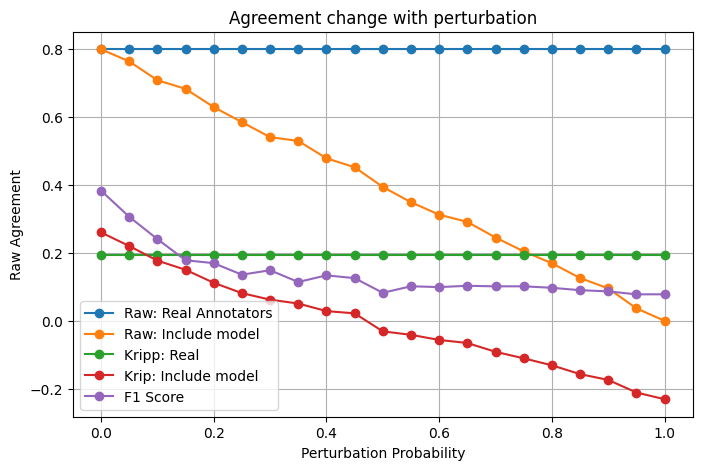

In [144]:
metrics = {"perturbation_prob": [], "k1": [], "k2": [], "raw": [], "raw_m": [], "f1_score": []}
df = data
for prob in perturbation_probs:
    prob = round(prob, 2)  # Round to 2 decimal places
    col_name = str(prob)  # Ensure column name matches expected format
    if col_name in df.columns:
        #subset = data[['Worker1', 'Worker2', 'Worker3', col_name]]
        ks = calculate_agreements(prob)
        k1 = raw_agreement(data[['Worker1', 'Worker2', 'Worker3']])
        k2 = raw_agreement(data[['Worker1','Worker2', 'Worker3', col_name]])
        k3 = ks[0].alpha()
        k4 = ks[1].alpha()
        f1 = f1_score(df["majority_vote"], df[col_name], average='binary')
        metrics["perturbation_prob"].append(prob)
        metrics["raw"].append(k1)
        metrics["raw_m"].append(k2)
        metrics["k1"].append(k3)
        metrics["k2"].append(k4)
        metrics["f1_score"].append(f1)

# Convert results into a DataFrame
metrics_df = pd.DataFrame(metrics)
# Plot results
plt.figure(figsize=(8,5))
plt.plot(metrics_df["perturbation_prob"], metrics_df["raw"], label="Raw: Real Annotators", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["raw_m"], label="Raw: Include model", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["k1"], label="Kripp: Real", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["k2"], label="Krip: Include model", marker='o')
plt.plot(metrics_df["perturbation_prob"], metrics_df["f1_score"], label="F1 Score", marker='o')

plt.xlabel("Perturbation Probability")
plt.ylabel("Raw Agreement")
plt.title("Agreement change with perturbation")
plt.legend()
plt.grid(True)
plt.show()

## Case 3: Average Agreement?



In [ ]:
from itertools import combinations
from sklearn.metrics import cohen_kappa_score


rater_pairs = list(combinations(data[['Worker1', 'Worker2', 'Worker3', '0.05']], 2))

# Compute Cohen’s Kappa for each pair
kappa_scores = {}
for r1, r2 in rater_pairs:
    kappa = cohen_kappa_score(df[r1], df[r2])
    kappa_scores[(r1, r2)] = kappa

for pair, score in kappa_scores.items():
    print(f"Cohen's Kappa between {pair[0]} and {pair[1]}: {score:.3f}")

Cohen's Kappa between Worker1 and Worker2: 0.049
Cohen's Kappa between Worker1 and Worker3: 0.152
Cohen's Kappa between Worker1 and 0.05: 0.649
Cohen's Kappa between Worker2 and Worker3: 0.345
Cohen's Kappa between Worker2 and 0.05: 0.033
Cohen's Kappa between Worker3 and 0.05: 0.136


In [ ]:
means = {'perturbance': [], 'mean_kappa': [], 'mean_kappa_anns': [], 'raw': [], 'raw_anns': []}
for prob in perturbation_probs:
    prob = round(prob, 2)  # Round to 2 decimal places
    col_name = str(prob)  # Ensure column name matches expected format
    # Compute Cohen’s Kappa for each pair
    rater_pairs = list(combinations(data[['Worker1', 'Worker2', 'Worker3', col_name]], 2))

    kappa_scores = {}
    for r1, r2 in rater_pairs:
        kappa = cohen_kappa_score(df[r1], df[r2])
        kappa_scores[(r1, r2)] = kappa

    rater_pairs = list(combinations(data[['Worker1', 'Worker2', 'Worker3']], 2))

    user_kappa_scores = {}
    for r1, r2 in rater_pairs:
        kappa = cohen_kappa_score(df[r1], df[r2])
        user_kappa_scores[(r1, r2)] = kappa

    means['perturbance'].append(prob)
    means['mean_kappa'].append(pd.Series(kappa_scores).mean())  
    means['mean_kappa_anns'].append(pd.Series(user_kappa_scores).mean())
    means['raw_anns'].append(raw_agreement(data[['Worker1', 'Worker2', 'Worker3']]))
    means['raw'].append(raw_agreement(data[['Worker1', 'Worker2', 'Worker3', col_name]]))

means
    

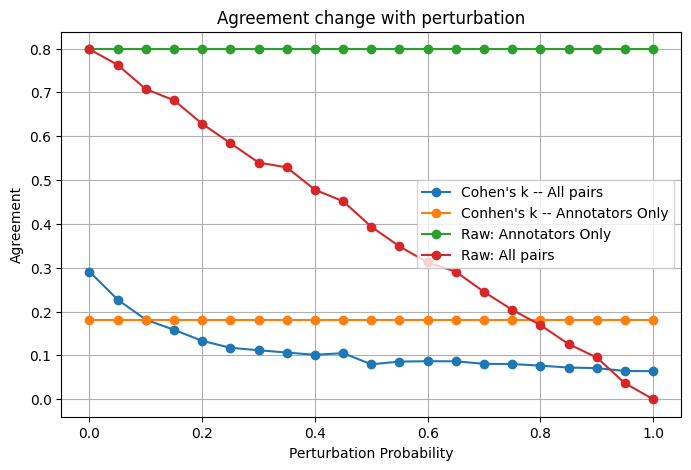

In [162]:
metrics_df = pd.DataFrame(means)
# Plot results
plt.figure(figsize=(8,5))
plt.plot(metrics_df["perturbance"], metrics_df["mean_kappa"], label="Cohen's k -- All pairs", marker='o')
plt.plot(metrics_df["perturbance"], metrics_df['mean_kappa_anns'], label="Conhen's k -- Annotators Only", marker='o')
plt.plot(metrics_df["perturbance"], metrics_df['raw_anns'], label="Raw: Annotators Only", marker='o')
plt.plot(metrics_df["perturbance"], metrics_df['raw'], label="Raw: All pairs", marker='o')

plt.xlabel("Perturbation Probability")
plt.ylabel("Agreement")
plt.title("Agreement change with perturbation")
plt.legend()
plt.grid(True)
plt.show()